In [6]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 41.6 MB/s 
     |████████████████████████████████| 15.4 MB 57.3 MB/s 


In [7]:
import psycopg2
import geopandas as gpd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

drive.mount('/content/drive/')

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Mounted at /content/drive/


In [8]:
df = pd.read_csv('drive/MyDrive/GOTECH/code/src/calip_dhw_giov2.csv')

In [16]:
## 0.1 Data config
dist_thresh = 10

# tar class available: label_baa_7d_max, crw_baa, label, class
tar_class = 'label'
tar_labels = [0, 1]
classes = ('Other', 'Coral')

# sampling methods available: smote, undersampling, random
sampling_method = 'undersampling'

## 0.2 Model Config 
NUM_EPOCHS = 100
BATCH_SIZE = 500

## 0.3 Path for saving model
PATH_OUTPUT = "../output/"
os.makedirs(PATH_OUTPUT, exist_ok=True)
model_name = 'CNN_undersample_maxabs_33m_ANN_100epochs'
file_name = model_name + '.pth'

# keep best model
best_val_acc = 0.0

In [17]:
# 1.2 subset data based on distance threshold
data = df[df.ac_distances < dist_thresh]

## 1.3 Data Prep 
# drop calipso na values
feat_cols = [c for c in df.columns if c[:4] == 'feat']

# use below with feature selection
# feat_cols = []
# for i in range(10):
#   feat_cols.append('feat_'+str(i))
# for i in range(7):
#   feat_cols.append('feat_'+str(i+205))
# for i in range(6):
#   feat_cols.append('feat_'+str(i+220))
# for i in range(21):
#   feat_cols.append('feat_'+str(i+279))

# feat_cols += ['par', 'chlor_a' ,'org_part', 'ino_part']
data.dropna(subset=feat_cols, inplace=True)

# drop baa na values
data.dropna(subset=[tar_class], inplace=True)

# drop calipso values < -100
data = data[(data[feat_cols] >= -100).any(1)]

# create X and y datasets 
subset_class = data[tar_class].isin(tar_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
if sampling_method == 'smote':
    X = data.loc[subset_class, feat_cols].values
    y = data.loc[subset_class, tar_class].values
    sm = SMOTE(random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm)
elif sampling_method == 'undersampling':
    
    # number of data points to randomly sample
    coral_size = data[data[tar_class] == 1].shape[0]
    train_coral_size = 4*coral_size//5
    
    other_size = coral_size//4
    train_other_size = 4 * other_size // 5
    
    # randomly undersample each class that's not coral
    rock_idx = list(np.random.choice(data[data['class'] == 'Rock'].index, size=other_size))
    rubble_idx = list(np.random.choice(data[data['class'] == 'Rubble'].index, size=other_size))
    sand_idx = list(np.random.choice(data[data['class'] == 'Sand'].index, size=other_size))
    seagrass_idx = list(np.random.choice(data[data['class'] == 'Seagrass'].index, size=other_size))
    coral_idx = list(np.random.choice(data[data[tar_class] == 1].index, size=coral_size))

    # split train/test dataset using index
    train_rock = rock_idx[:train_other_size]
    train_rubble = rubble_idx[:train_other_size]
    train_sand = sand_idx[:train_other_size]
    train_seagrass =  seagrass_idx[:train_other_size]
    train_coral = coral_idx[:train_coral_size]

    test_rock = rock_idx[train_other_size:]
    test_rubble = rubble_idx[train_other_size:]
    test_sand = sand_idx[train_other_size:]
    test_seagrass =  seagrass_idx[train_other_size:]
    test_coral = coral_idx[train_coral_size:]

    # combine indices for test and train datasets
    test_idx = test_coral + test_rock + test_rubble + test_sand + test_seagrass
    train_idx = train_coral + train_rock + train_rubble + train_sand + train_seagrass

    X_train = data.loc[train_idx, feat_cols].values
    y_train = data.loc[train_idx, tar_class].values
    X_test = data.loc[test_idx, feat_cols].values
    y_test = data.loc[test_idx, tar_class].values

In [19]:
# Reshape the size for CNN model
x_train = X_train.reshape(X_train.shape[0], 30, 10).astype('float32')
x_test = X_test.reshape(X_test.shape[0], 30, 10).astype('float32')

# Only use below for selected features
# x_train = X_train.reshape(X_train.shape[0], 11, 4).astype('float32')
# x_test = X_test.reshape(X_test.shape[0], 11, 4).astype('float32')

In [20]:
# CNN Model
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import Dropout

n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[0]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.fit(x_train, y_train.reshape(y_train.shape[0],1,1), epochs=100, batch_size=16)

Epoch 1/100
484/484 [==============================] - 4s 7ms/step - loss: 0.9398 - binary_accuracy: 0.6195
Epoch 2/100
484/484 [==============================] - 3s 6ms/step - loss: 0.7276 - binary_accuracy: 0.6389
Epoch 3/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6655 - binary_accuracy: 0.6400
Epoch 4/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6374 - binary_accuracy: 0.6470
Epoch 5/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6303 - binary_accuracy: 0.6511
Epoch 6/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6342 - binary_accuracy: 0.6574
Epoch 7/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6331 - binary_accuracy: 0.6596
Epoch 8/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6292 - binary_accuracy: 0.6627
Epoch 9/100
484/484 [==============================] - 3s 6ms/step - loss: 0.6192 - binary_accuracy: 0.6631
Epoch 10/100
484/484 [======

In [21]:
# Check the performance of the CNN model
model.evaluate(x_test, y_test, batch_size=16)

121/121 [==============================] - 0s 3ms/step - loss: 0.9538 - binary_accuracy: 0.7659


[0.9537935853004456, 0.7658914923667908]

In [23]:
from sklearn.metrics import confusion_matrix
pred = (model.predict(x_test) > 0.45).astype(int)
con = confusion_matrix(y_test,pred)

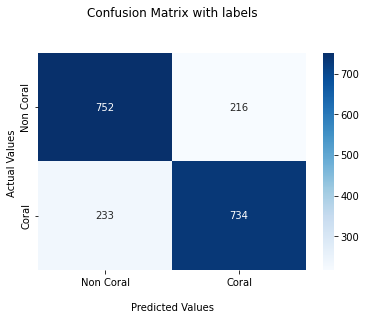

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

con = confusion_matrix(y_test,pred)
ax = sns.heatmap(con, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non Coral','Coral'])
ax.yaxis.set_ticklabels(['Non Coral','Coral'])

## Display the visualization of the Confusion Matrix.
plt.show()